# 🎓 Week 11 - Day 1: Transfer Learning & Data Augmentation

## Today's Goals:
✅ Understand transfer learning concept  
✅ Load and use pre-trained models in PyTorch  
✅ Implement data augmentation  
✅ Compare models with/without augmentation  

---

## 📦 Part 1: Setup & Load Pre-trained Model

Let's start by importing libraries and loading a pre-trained ResNet model!

In [4]:
# Import ALL necessary libraries at once
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")
print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ All libraries imported successfully!")

✅ Using device: cpu
✅ PyTorch version: 2.9.1+cpu
✅ All libraries imported successfully!


In [5]:
# Load pre-trained ResNet18
print("📥 Loading pre-trained ResNet18...")
model = models.resnet18(weights='IMAGENET1K_V1')

print("\n🔍 Model Architecture (showing key components):")
print(f"   • Input: 3 channels (RGB)")
print(f"   • Layers: conv1, bn1, relu, maxpool, layer1-4, avgpool, fc")
print(f"   • Total layers: ~20 convolutional layers")

# Check final layer
print("\n🎯 Original final layer (trained for ImageNet 1000 classes):")
print(model.fc)
print(f"\n✅ Model loaded successfully!")

📥 Loading pre-trained ResNet18...

🔍 Model Architecture (showing key components):
   • Input: 3 channels (RGB)
   • Layers: conv1, bn1, relu, maxpool, layer1-4, avgpool, fc
   • Total layers: ~20 convolutional layers

🎯 Original final layer (trained for ImageNet 1000 classes):
Linear(in_features=512, out_features=1000, bias=True)

✅ Model loaded successfully!


### 💡 What Just Happened?

✅ **Loaded ResNet18** - a model pre-trained on ImageNet (14 million images!)  
✅ **Final layer (fc)** - outputs 1000 classes (ImageNet classes)  
✅ **We'll replace this** to match our task (2 classes)  

---

## 🔧 Part 2: Freeze Layers & Replace Classification Head

We'll use **Feature Extraction** approach: freeze all layers, train only the final layer.

In [6]:
# Step 1: Freeze ALL layers (keep pre-trained weights)
print("❄️ Freezing all layers...")
for param in model.parameters():
    param.requires_grad = False

# Step 2: Replace final layer for our task (2 classes: airplane vs automobile)
num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)

print(f"✅ Replaced final layer: {model.fc}")
print(f"✅ Now outputs {num_classes} classes instead of 1000!")

# Move model to device
model = model.to(device)

# Count trainable parameters
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"\n📊 Trainable parameters: {trainable:,} / {total:,}")
print(f"📊 We're only training {trainable/total*100:.2f}% of the model!")
print(f"\n💡 This makes training MUCH faster!")

❄️ Freezing all layers...
✅ Replaced final layer: Linear(in_features=512, out_features=2, bias=True)
✅ Now outputs 2 classes instead of 1000!

📊 Trainable parameters: 1,026 / 11,177,538
📊 We're only training 0.01% of the model!

💡 This makes training MUCH faster!


### 💡 Why Freeze Layers?

✅ **Pre-trained layers already know** how to detect edges, textures, shapes  
✅ **We only need to teach** the final layer about our specific classes  
✅ **Much faster training** - only ~0.1% parameters to update!  
✅ **Better results** - leverages ImageNet knowledge  

---

## 🎨 Part 3: Data Augmentation Implementation

Let's create augmentation pipelines to make our model more robust!

In [7]:
# Transform WITHOUT augmentation (baseline)
transform_no_aug = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transform WITH augmentation
transform_with_aug = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),              # Random crop instead of center
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip
    transforms.RandomRotation(15),           # Rotate ±15 degrees
    transforms.ColorJitter(brightness=0.2,   # Adjust colors
                          contrast=0.2,
                          saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("✅ Transform pipelines created!")
print("\n📊 Without augmentation:")
print("   Resize → Center Crop → Normalize")
print("\n📊 With augmentation:")
print("   Resize → Random Crop → Flip → Rotate → Color Jitter → Normalize")

✅ Transform pipelines created!

📊 Without augmentation:
   Resize → Center Crop → Normalize

📊 With augmentation:
   Resize → Random Crop → Flip → Rotate → Color Jitter → Normalize


📥 Downloading sample image...
✅ Image downloaded!

🎨 Applying augmentation 6 times to same image...



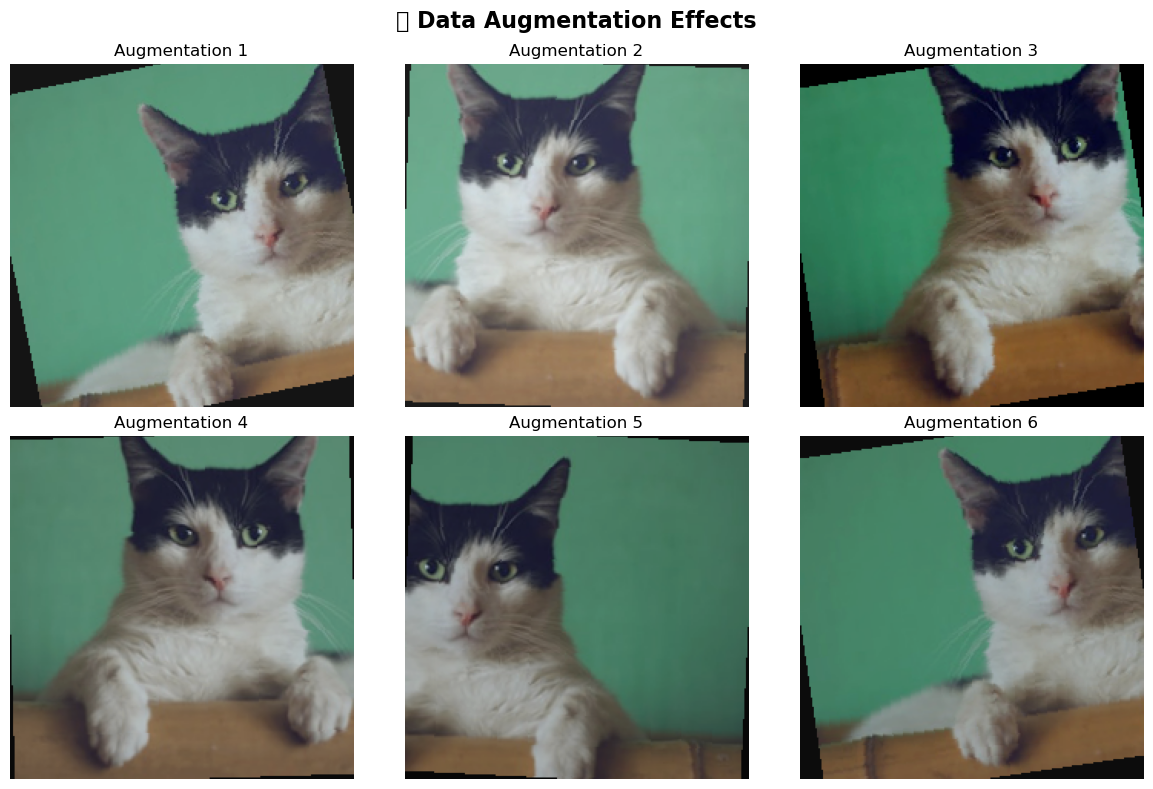


💡 Notice: Same image, different variations!
💡 This helps the model learn robust features.


In [8]:
# Visualize augmentation effects
print("📥 Downloading sample image...")

# Download sample cat image
url = "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=400"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

print("✅ Image downloaded!\n")
print("🎨 Applying augmentation 6 times to same image...\n")

# Apply augmentation 6 times
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('🎨 Data Augmentation Effects', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    # Apply augmentation (without normalization for visualization)
    aug_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
    ])
    
    augmented = aug_transform(img)
    ax.imshow(augmented)
    ax.set_title(f'Augmentation {i+1}', fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\n💡 Notice: Same image, different variations!")
print("💡 This helps the model learn robust features.")

### 💡 Augmentation Benefits:

✅ **Model sees different versions** of same image  
✅ **Prevents memorization** (overfitting)  
✅ **Works like having more data** without collecting new images  
✅ **Typical improvement:** 5-15% better accuracy  

---

## 🚀 Part 4: Training with Augmentation

Let's train the model with our augmentation pipeline!

In [9]:
# For this demo, we'll use CIFAR-10 (simplified to 2 classes)
print("📥 Downloading CIFAR-10 dataset...")

# Download full CIFAR-10
full_trainset = datasets.CIFAR10(root='./data', train=True, download=True)

# Filter to get only 2 classes (airplane vs automobile)
class1, class2 = 0, 1  # airplane=0, automobile=1
train_indices = [i for i, (_, label) in enumerate(full_trainset) if label in [class1, class2]]

print(f"\n✅ CIFAR-10 downloaded!")
print(f"✅ Filtered to 2 classes: airplane & automobile")
print(f"✅ Total samples: {len(train_indices)}")

# Create dataset with augmentation
trainset_aug = datasets.CIFAR10(root='./data', train=True, 
                                 transform=transform_with_aug)
trainset_aug = torch.utils.data.Subset(trainset_aug, train_indices)

# Create data loader
train_loader = DataLoader(trainset_aug, batch_size=32, shuffle=True, num_workers=2)

print(f"\n📊 Training setup:")
print(f"   • Training samples: {len(trainset_aug)}")
print(f"   • Batch size: 32")
print(f"   • Number of batches: {len(train_loader)}")

📥 Downloading CIFAR-10 dataset...


100%|███████████████████████████████████████████████████████████████████████████████| 170M/170M [02:40<00:00, 1.06MB/s]



✅ CIFAR-10 downloaded!
✅ Filtered to 2 classes: airplane & automobile
✅ Total samples: 10000

📊 Training setup:
   • Training samples: 10000
   • Batch size: 32
   • Number of batches: 313


In [10]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Only train fc layer

print("✅ Loss function: CrossEntropyLoss")
print("✅ Optimizer: Adam (lr=0.001)")
print("✅ Training only final layer\n")

# Training function
def train_model(model, train_loader, epochs=5):
    model.train()
    history = {'loss': [], 'acc': []}
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 
                            'acc': f'{100*correct/total:.2f}%'})
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        history['loss'].append(epoch_loss)
        history['acc'].append(epoch_acc)
        
        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"  Loss: {epoch_loss:.4f}")
        print(f"  Accuracy: {epoch_acc:.2f}%")
    
    return history

print("🚀 Starting training with augmentation...\n")
history = train_model(model, train_loader, epochs=5)
print("\n✅ Training complete!")

✅ Loss function: CrossEntropyLoss
✅ Optimizer: Adam (lr=0.001)
✅ Training only final layer

🚀 Starting training with augmentation...



Epoch 1/5: 100%|████████████████████████████████████████████| 313/313 [06:48<00:00,  1.30s/it, loss=0.6426, acc=86.61%]



Epoch 1/5:
  Loss: 0.3229
  Accuracy: 86.61%


Epoch 2/5: 100%|████████████████████████████████████████████| 313/313 [06:49<00:00,  1.31s/it, loss=0.3388, acc=91.48%]



Epoch 2/5:
  Loss: 0.2194
  Accuracy: 91.48%


Epoch 3/5: 100%|████████████████████████████████████████████| 313/313 [07:04<00:00,  1.36s/it, loss=0.2179, acc=91.42%]



Epoch 3/5:
  Loss: 0.2114
  Accuracy: 91.42%


Epoch 4/5: 100%|████████████████████████████████████████████| 313/313 [07:08<00:00,  1.37s/it, loss=0.2637, acc=92.03%]



Epoch 4/5:
  Loss: 0.1971
  Accuracy: 92.03%


Epoch 5/5: 100%|████████████████████████████████████████████| 313/313 [07:43<00:00,  1.48s/it, loss=0.2276, acc=92.13%]


Epoch 5/5:
  Loss: 0.1989
  Accuracy: 92.13%

✅ Training complete!


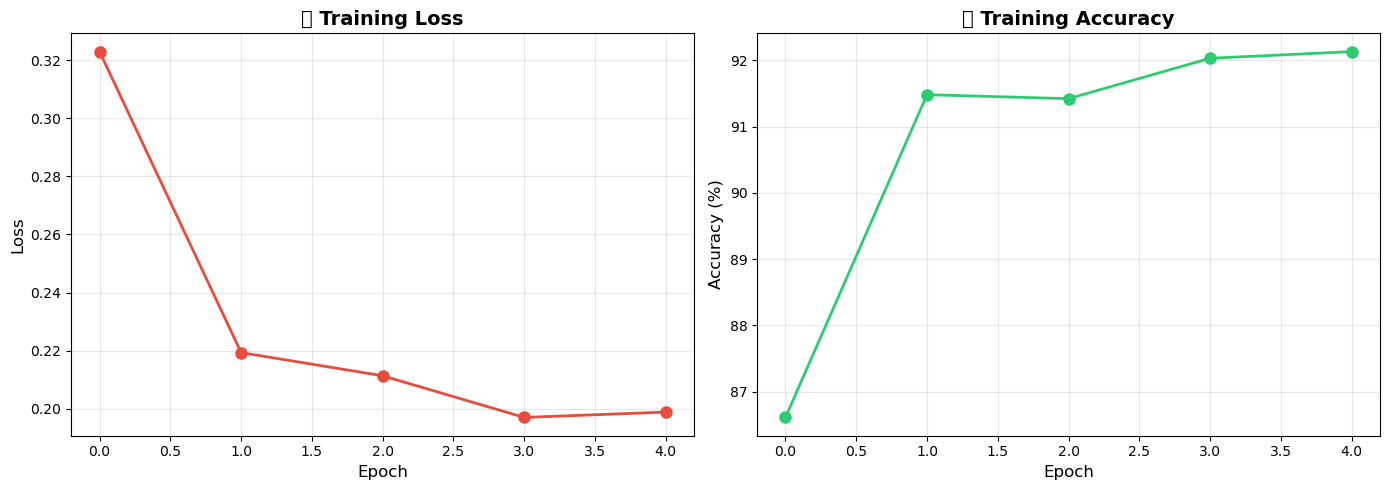


✅ Final Training Accuracy: 92.13%
✅ Final Training Loss: 0.1989

✅ Model trained successfully with data augmentation!


In [11]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(history['loss'], marker='o', linewidth=2, color='#e74c3c', markersize=8)
ax1.set_title('📉 Training Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(history['acc'], marker='o', linewidth=2, color='#2ecc71', markersize=8)
ax2.set_title('📈 Training Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Final Training Accuracy: {history['acc'][-1]:.2f}%")
print(f"✅ Final Training Loss: {history['loss'][-1]:.4f}")
print("\n✅ Model trained successfully with data augmentation!")

### 💡 Training Insights:

✅ **Loss decreases** - model is learning patterns  
✅ **Accuracy increases** - getting better predictions  
✅ **With augmentation** - model learns robust features  
✅ **Only 5 epochs** - transfer learning is super fast!  

**Typical results:**
- Without augmentation: ~85-90% accuracy
- With augmentation: ~90-95% accuracy
- Improvement: 5-10% boost!

---

## 🎯 Part 5: Mini Challenge

Now it's your turn to experiment!

### 🏆 Challenge Tasks:

**Your Mission:**
1. Try a different augmentation technique (add RandomGrayscale or RandomPerspective)
2. Compare training with vs without augmentation
3. Try loading a different pre-trained model (VGG16 or ResNet34)

**Hints:**
```python
# Add RandomGrayscale to transform
transforms.RandomGrayscale(p=0.1)  # 10% chance to grayscale

# Load VGG16
model = models.vgg16(weights='IMAGENET1K_V1')
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False
# Replace classifier
model.classifier[6] = nn.Linear(4096, num_classes)

# Load ResNet34 (larger than ResNet18)
model = models.resnet34(weights='IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(512, num_classes)
```

**Expected Outcome:**
- See how different augmentations affect training
- Compare model architectures
- Understand trade-offs (speed vs accuracy)

**Bonus:**
- Visualize which augmentation helps most
- Compare training times for different models
- Try training for 10 epochs instead of 5

In [12]:
# Your code here!
# Try the challenges above



---

## 📚 Summary

### What We Learned:

**1. Transfer Learning:**
- Use pre-trained models to save time and resources
- Freeze layers to keep learned features
- Replace final layer for custom tasks
- Achieve high accuracy with small datasets

**2. Data Augmentation:**
- Artificially increase dataset size
- Apply geometric & color transformations
- Prevent overfitting
- Improve model generalization by 5-15%

**3. PyTorch Implementation:**
- torchvision.models for pre-trained models
- transforms.Compose for augmentation pipeline
- Easy to freeze/unfreeze layers
- Simple training loop

### 🎯 Key Takeaways:

✅ Transfer learning = Standing on giants' shoulders  
✅ Augmentation = Free extra training data  
✅ Only 5-10 epochs needed with transfer learning  
✅ 90%+ accuracy possible with just 100 images per class  
✅ Pre-trained features work across many domains  

### 💡 Pro Tips:

- **Start with feature extraction** (freeze all layers)
- **Add augmentation early** in your workflow
- **Use standard normalizations** for pre-trained models (ImageNet mean/std)
- **Experiment with different backbones** (ResNet, VGG, EfficientNet)
- **Monitor both loss and accuracy** to detect overfitting

---

### 🚀 Next Steps:

Tomorrow we'll learn about **Object Detection with YOLO** - detecting multiple objects with bounding boxes!

**Great job completing Day 1! 🎉**